MobileSAM Demo

In [1]:
# Check we are using correct venv virtual environment
import sys
print(f"Python: {sys.executable}")
print(f"In venv: {'venv' in sys.prefix or 'virtualenv' in sys.prefix}")

Python: c:\Users\lisaf\Documents\GitHub\GenGami\venv\Scripts\python.exe
In venv: True


In [2]:
# Fresh start
import torch
import torchvision
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.9.1+cpu
Torchvision version: 0.24.1+cpu


In [5]:
# Silence warnings
import warnings
warnings.filterwarnings("ignore")

from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
print("Imported mobile_sam")

Imported mobile_sam


In [6]:
import cv2
# Import sample bird image
image_path = "./bird.jpg"

# Method 1: Using OpenCV (recommended - MobileSAM expects BGR format)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

In [15]:
import numpy as np
# Now provide input prompts (point, box, or mask)
# Example 1: Using a point prompt (x, y coordinates)
input_point = np.array([[400, 200]])  # Click coordinates
input_label = np.array([1])  # 1 = foreground, 0 = background


In [16]:
model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

predictor = SamPredictor(mobile_sam)
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [17]:
# from mobile_sam import SamAutomaticMaskGenerator

# mask_generator = SamAutomaticMaskGenerator(mobile_sam)
# masks = mask_generator.generate(image)

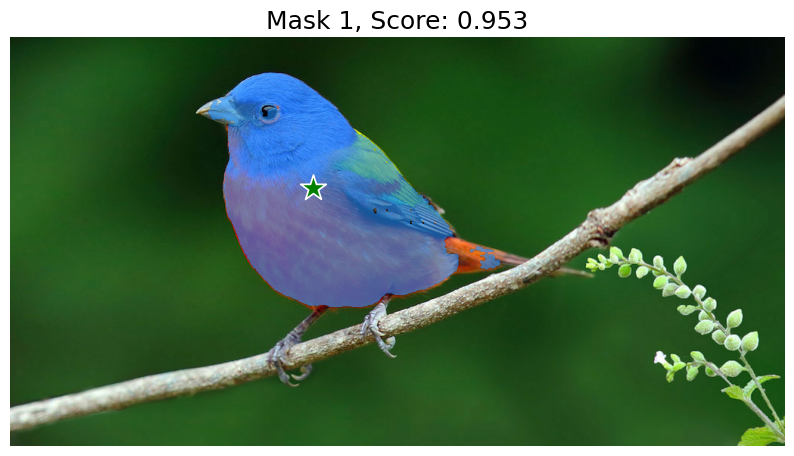

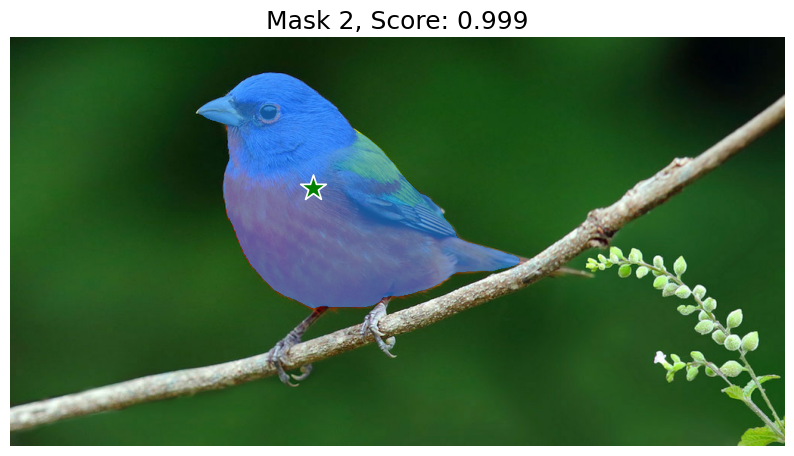

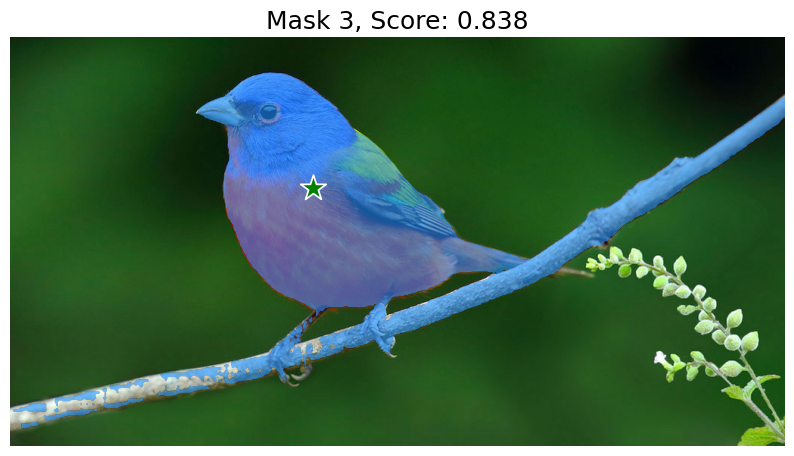

In [18]:
# Visualize masks
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Visualize all masks
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()